# LVL2 Script

In [1]:
#import external libraries
import pandas as pd
import os
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt

#plotting
%matplotlib notebook

#import self-written libraries
import LVL1
from settings import Glacier, Station, base_path, temp_columns, precip_columns, wind_col, out_columns, primary_temp_column, wind_dir_columns
import CleanWxData as wx

In [2]:
#Data Import Tasks
#path to level 1 data
timezone='America/Anchorage' #choose from pytz.all_timezones

file_label='_15min'
yr='all' #either "all" or the year you want

pth=base_path + "Data/" +Glacier+ r"/AllYears/Wx/LVL1/" + Glacier.lower()+Station+file_label+yr+".csv"

#time format and column
Local_time_column_name='Local_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/"

In [3]:
#read in level1 CSV
dat=pd.read_csv(pth)
print(pth)

Q:/Project Data/GlacierData/Benchmark_Program/Data/JuneauIcefield/AllYears/Wx/LVL1/juneauicefield2121_15minall.csv


In [4]:
dat['local_time']=pd.to_datetime(dat[Local_time_column_name], format= date_format)
dat=dat.set_index('local_time') #set this local time as the index

In [5]:
#TRANSFER THIS BOX TO THE SETTINGS FILE LATER

# #Give names of columns containing temperature, and precipitation data, data for general averaging, and wind direction
# temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']

# if (Glacier +Station=='Gulkana1920')| (Glacier + Station=='Wolverine1420'):
#     primary_temp_column='Tpassive1'
# #unaspirated_temp_columns=['Tpassive1', 'Tpassive2']


# if Glacier +Station=='Wolverine370':
#     precip_columns=['TipCumulative']
#     general_data_columns=['Discharge']
#     primary_temp_column='Tpassive1'

In [6]:
incremental_precip_columns=[] #create names for incremental precip columns
for precip_col in precip_columns:
    col_name=precip_col.split("Cumulative")[0]+"Incremental"
    incremental_precip_columns.append(col_name)
    dat[col_name]=dat[precip_col]-dat[precip_col].shift(1)
    if not np.isnan(dat[precip_col][0]):
        dat.ix[0, col_name]=0 #set first value to 0, not NAN IF the initial cumulative series was also not null

# Fill Gaps -temp
 #### * 15 min data

In [7]:
#dat[precip_columns].plot()

In [8]:
#Store original primary sensor data for later comparrison
dat['orig_T1']=dat[primary_temp_column].copy()

In [9]:
#List alternate temp columns
secondary_temp_columns=list(set(temp_columns)-set([primary_temp_column]))
passive_temp_columns=[s for s in temp_columns if "passive" in s]

In [10]:
#Temperature - fill short gaps < 1hr in all temperature records
for col in temp_columns:
    print(col)
    dat.loc[:,col]=dat[col].interpolate(method='linear', limit=3)

Tpassive1


In [11]:
#Store locations of long NAN gaps in primary sensor record to be filled
primary_temp_null_indx=dat[primary_temp_column].isnull()

In [12]:
#Subset data to alternate temperature columns
secondary_temp_dat=dat[secondary_temp_columns].copy()

#Check if any secondary temp sensors exist
secondary_temps_exist= not secondary_temp_dat.dropna(how='all').empty


In [13]:
if secondary_temps_exist:    
    #Calculate the mean of the secondary temp values
    secondary_temp_dat['temp_mean']=secondary_temp_dat[secondary_temp_columns].mean(axis=1)
    #Calculate standard dev. of secondary temp values
    secondary_temp_dat['temp_sd']=secondary_temp_dat[secondary_temp_columns].std(axis=1)
    #Calculate temperature difference between avg. of other temperatures
    secondary_temp_dat['temp_diff']=abs(dat[primary_temp_column]-secondary_temp_dat.mean(axis=1))
    #Calculate the median of secondary temp values
    secondary_temp_dat['temp_median']=secondary_temp_dat[secondary_temp_columns].median(axis=1)
    #Calculate mean of passive temperature sensors (if a sensor is missing, mean will be NAN)
    secondary_temp_dat['passive_average']=dat[passive_temp_columns].mean(axis=1, skipna=False)
    #Calculate difference of 2 passive sensors from one another
    secondary_temp_dat['passive_difference_between_sensors']=abs(dat[passive_temp_columns[0]]-dat[passive_temp_columns[1]])

    #ID times when more than 1 secondary temperature sensor is available
    more_than_one_passive_temp_avail_idx=secondary_temp_dat[passive_temp_columns].notnull().sum(axis=1)>1

    #ID variation among other sensors
    low_variation_secondary_sensors_idx=secondary_temp_dat[secondary_temp_columns].std(axis=1)<1.5

    #Fill remaining gaps (>3 length) in primary timeseries with average of all other sensors, when > 1 available
    dat.loc[dat[primary_temp_column].isnull() & low_variation_secondary_sensors_idx, primary_temp_column]=secondary_temp_dat.temp_median[dat[primary_temp_column].isnull()&low_variation_secondary_sensors_idx]

    #Find places where passive differs from aspirated
    asp_more_than_2deg_diff_from_passivemean_idx=(abs(dat[primary_temp_column]- secondary_temp_dat.passive_average))>2 #difference between asp and passive mean > 2 deg
    #pass_colder_than_asp_over_halfdeg_idx=(dat[primary_temp_column]- secondary_temp_dat.passive_average)>0.5

    #In places where the passive AGREE with eachother, but DISAGREE with the aspirated mean, set main aspirated T to mean of passive.
    passive_sensors_agree_with_eachother_halfdeg_idx=secondary_temp_dat.passive_difference_between_sensors<0.5 #passive sensors agree with eachother (<0.5 deg diff)

    #Replace data in Aspirated with Passive mean where asp disagrees with passive, and more than 1 secondary temp sensor available
    dat.loc[asp_more_than_2deg_diff_from_passivemean_idx &
            passive_sensors_agree_with_eachother_halfdeg_idx &
            more_than_one_passive_temp_avail_idx, 
            primary_temp_column]=secondary_temp_dat.loc[asp_more_than_2deg_diff_from_passivemean_idx &
                                                        passive_sensors_agree_with_eachother_halfdeg_idx &
                                                        more_than_one_passive_temp_avail_idx,'passive_average'] 

    #Fill remaining NANs in primary temperature time series with median of all other sensors, where variation is low
    dat.loc[dat[primary_temp_column].isnull() & 
            low_variation_secondary_sensors_idx,
            primary_temp_column]=secondary_temp_dat.temp_median[dat[primary_temp_column].isnull() &
                                                               low_variation_secondary_sensors_idx]

    #Temporarily fill remaining NANs in primary timeseries, in order to do outlier stripping
    Nan_locations_to_restore=dat[primary_temp_column].isnull()
    dat.loc[dat[primary_temp_column].isnull(), primary_temp_column]=secondary_temp_dat.temp_median[dat[primary_temp_column].isnull()]
else:
    print('no secondary temperatures; keeping primary as-is')

no secondary temperatures; keeping primary as-is


In [14]:
#Remove bad sensor data, where a value is >4 degrees different from the 2-hour median temp. 
for temp_col in temp_columns:
    dat[temp_col]=LVL1.hampel(dat[temp_col], k=7) #remove outliers with hampel filter
    dat[temp_col]=LVL1.basic_median_outlier_strip(dat[temp_col], k=8, threshold=4, min_n_for_val=3) #remove remaining outliers; spikes where val exceeds 2-hr rolling median by 4C    

In [15]:
if secondary_temps_exist:    
    #Restore NANs back into timeseries, where we are unsure which secondary sensors are best to use
    dat.loc[Nan_locations_to_restore, primary_temp_column]=np.nan

    dat['full_count'] = dat[secondary_temp_columns].apply(lambda x: x.count(), axis=1) #count how many temperature obs we have for a given time

    #At times where secondary temperature sensors do not agree, but more than one is present, expert judgment should be used.
    #To implement this, identify the period during which a secondary sensor is malfunctioning, and enter into "error" step in LVL1 script
    if len(dat[dat[primary_temp_column].isnull() &dat.full_count>1])>0:
        print("secondary sensors do not agree; manually determine which should be used here, and add bad to list in LVL1 processing")

    #If primary record NANs still remain, substitute median of alternate temperatures
    if len(dat[dat[primary_temp_column].isnull() &dat.full_count>1])==0:
        dat.loc[dat[primary_temp_column].isnull(), primary_temp_column]=secondary_temp_dat.temp_median[dat[primary_temp_column].isnull()]
else:
    print('no secondary temperatures; keeping primary as-is')

no secondary temperatures; keeping primary as-is


<IPython.core.display.Javascript object>


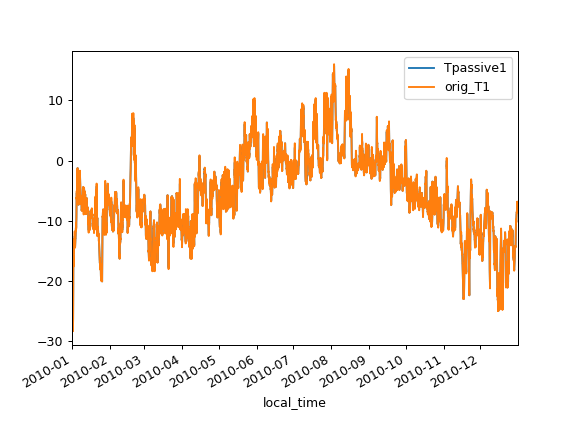

In [16]:
dat[temp_columns+ ['orig_T1']]['2010'].plot() #this shows the 15 min still has holes; interpolation is whats going down

In [17]:
#Calculate vector-average wind direction if not already present
if 'WindSpeed' in dat.columns:
    dat.loc[dat.VecAvgWindDir.isnull(), 'VecAvgWindDir']=LVL1.vector_average_wind_direction_individual_timestep(WS=dat.WindSpeed[dat.VecAvgWindDir.isnull()], WD=dat.WindDir[dat.VecAvgWindDir.isnull()])

In [18]:
#Run this to see all times where we are missing temperature data and need to fill it.
#dat[dat[temp_columns].isnull().all(axis=1)]

In [19]:
general_data_columns=[]

## Save final 15 minute data

In [20]:
out_columns=[primary_temp_column] +incremental_precip_columns+general_data_columns #columns to include in output
save_name=Glacier.lower()+ Station + "_15min_"+"LVL2.csv" #filename
save_pth=os.path.join(save_dir, save_name)

In [21]:
dat[out_columns].to_csv(save_pth, float_format='%g', date_format=date_format) #save data

# Hourly Data

In [22]:
#Temperature - fill gaps in primary temperature under 1 hour
dat_before_fill=dat.copy()
for temp_col in temp_columns:
    dat.loc[:,temp_col]=dat[temp_col].interpolate(method='linear', limit=3)

In [23]:
hourly_dat=pd.DataFrame()

In [24]:
#Create Hourly Data -
#Temperature
hourly_dat=pd.DataFrame()
for temp_col in temp_columns:
    #Create WMO Mean Temp
    hourly_dat[temp_col+"_min"]=wx.aggregate_time_with_threshold(dat[temp_col], 'H', steps_in_period=4, func='min')
    hourly_dat[temp_col+ "_max"]=wx.aggregate_time_with_threshold(dat[temp_col], 'H', steps_in_period=4, func='max')
    hourly_dat[temp_col+"_WMO"]=hourly_dat[[temp_col+"_min", temp_col+'_max']].mean(axis=1)
    #Create USGS Mean Temp
    hourly_dat[temp_col+"_USGS"]=wx.aggregate_time_with_threshold(dat[temp_col], 'H', steps_in_period=4, func='mean')
    
#Precipitation
for incremental_precip_col in incremental_precip_columns:
    hourly_dat[incremental_precip_col]=dat[incremental_precip_col].resample('H', label='left').sum() #all precip recieved during his hour
    
#Other Data Types (that can be aggregated with a simple mean)
for general_data_col in general_data_columns:
    hourly_dat[general_data_col]=wx.aggregate_time_with_threshold(dat[general_data_col], 'H', steps_in_period=4, func='mean')

if len(wind_dir_columns)>0:
    #Wind Direction - this process is for data that is logged as vector-averaged 
      # for data that is not, use LVL1.vector_average_wind_direction()
    for wd_col in wind_dir_columns:
        #Convert to raidans
        dat['wind_dir_cos']=np.cos(dat[wd_col]*(np.pi/180))
        dat['wind_dir_sin']=np.sin(dat[wd_col]*(np.pi/180))

        #Calculate mean of x and y directions in radian space
        hourly_dat['wind_dir_cos']=wx.aggregate_time_with_threshold(dat.wind_dir_cos, 'H', steps_in_period=4, func='mean')
        hourly_dat['wind_dir_sin']=wx.aggregate_time_with_threshold(dat.wind_dir_sin, 'H', steps_in_period=4, func='mean')
        #Convert back to 0-360 coordinates
        hourly_dat[wd_col]=(np.arctan2(hourly_dat.wind_dir_sin, hourly_dat.wind_dir_cos) * 180/np.pi)
        hourly_dat.loc[hourly_dat[wd_col]<0, wd_col]+=360 #add 360 where hourly dat less than 0

In [25]:
if 'Discharge' in dat.columns:
    hourly_dat['Discharge']=wx.aggregate_time_with_threshold(dat['Discharge'], 'H', steps_in_period=4, func='sum')

<IPython.core.display.Javascript object>


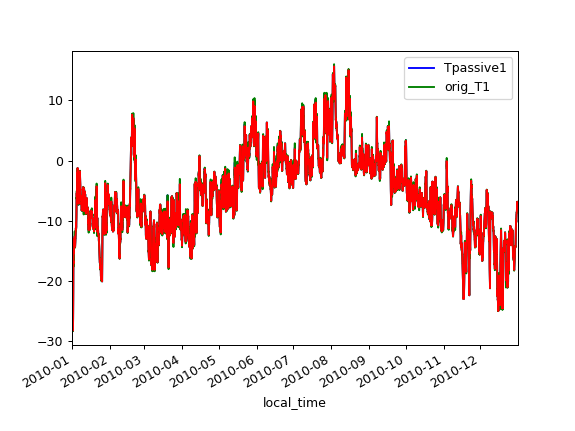

In [26]:
ax=dat[temp_columns+ ['orig_T1']]['2010'].plot(color=['blue', 'green']) #this shows the 15 min still has holes; interpolation is whats going down
hourly_dat['Tpassive1_USGS']['2010'].plot(ax=ax, color='red')

<IPython.core.display.Javascript object>


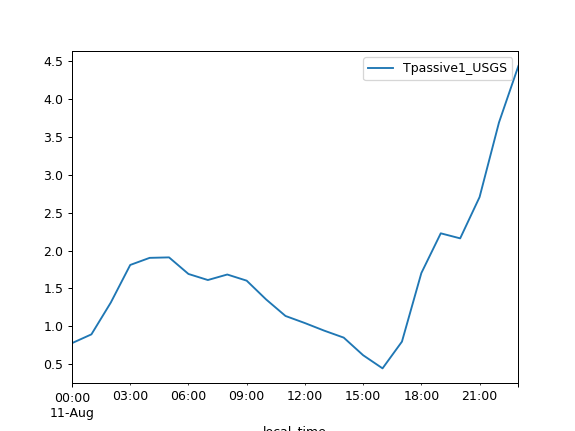

In [27]:
usgs_temp_cols=hourly_dat.columns[hourly_dat.columns.str.contains("USGS")]
#plt.figure()
hourly_dat[usgs_temp_cols]['2010-08-11'].plot()

#### Save Data

In [28]:
out_temp_columns = [s for s in hourly_dat.columns if primary_temp_column in s]

out_columns=out_temp_columns+incremental_precip_columns+general_data_columns+ wind_dir_columns #columns to include in output
if Glacier+Station=='Wolverine370':
    out_columns=out_temp_columns+incremental_precip_columns+general_data_columns
save_name=Glacier.lower()+ Station + "_hourly_"+"LVL2.csv" #filename
save_pth=os.path.join(save_dir, save_name)

hourly_dat[out_columns][:-1].to_csv(save_pth, float_format='%g', date_format=date_format) #write selected columns; omit last row (unlikely to be complete, with download)
print(save_pth)

Q:/Project Data/GlacierData/Benchmark_Program/Data/JuneauIcefield/AllYears/Wx/LVL2/juneauicefield2121_hourly_LVL2.csv


# Daily Data

In [29]:
#Temperature - fill gaps under 3 hours before aggregation
dat=dat_before_fill.copy() #reset 'dat' to be un-interpolated data
for temp_col in temp_columns:
    dat.loc[:,temp_col]=dat[temp_col].interpolate(method='linear', limit=12) #<= 3hrs;  at a 15 min interval, 3 hrs is 12 measurements

In [30]:
daily_dat=pd.DataFrame() #create empty dataframe
daily_quality_df=pd.DataFrame()

#Temperature
for temp_col in temp_columns:
    #Create WMO Mean Temp
    daily_dat[temp_col+"_min"]=wx.aggregate_time_with_threshold(dat[temp_col], 'D', steps_in_period=96, func='min')
    daily_dat[temp_col+ "_max"]=wx.aggregate_time_with_threshold(dat[temp_col], 'D', steps_in_period=96, func='max')
    daily_dat[temp_col+"_WMO"]=daily_dat[[temp_col+"_min", temp_col+'_max']].mean(axis=1)
    #Create USGS Mean Temp
    daily_dat[temp_col+"_USGS"]=wx.aggregate_time_with_threshold(dat[temp_col], 'D', steps_in_period=96, func='mean')   
    
#Precipitation
for incremental_precip_col in incremental_precip_columns:
    daily_dat[incremental_precip_col]=dat[incremental_precip_col].resample('D', label='left').sum() #all precip recieved during this day; label on right
    
#Other Data Types (that can be aggregated with a simple mean)
for general_data_col in general_data_columns:
    daily_dat[general_data_col]=wx.aggregate_time_with_threshold(dat[general_data_col], 'D', steps_in_period=96, func='mean') 

    
if len(wind_dir_columns)>0:    
    #Wind Direction - this process is for data that is logged as vector-averaged 
      # for data that is not, use LVL2.vector_average_wind_direction to create
    for wd_col in wind_dir_columns:
        #Convert to raidans
        dat['wind_dir_cos']=np.cos(dat[wd_col]*(np.pi/180))
        dat['wind_dir_sin']=np.sin(dat[wd_col]*(np.pi/180))

        #Calculate mean of x and y directions in radian space
        daily_dat['wind_dir_cos']=wx.aggregate_time_with_threshold(dat.wind_dir_cos, 'D', steps_in_period=96, func='mean')
        daily_dat['wind_dir_sin']=wx.aggregate_time_with_threshold(dat.wind_dir_sin, 'D', steps_in_period=96, func='mean')

        #Convert back to 0-360 coordinates
        daily_dat[wd_col]=(np.arctan2(daily_dat.wind_dir_sin, daily_dat.wind_dir_cos) * 180/np.pi)
        daily_dat.loc[daily_dat[wd_col]<0, wd_col]+=360

In [31]:
if 'Discharge' in dat.columns:
    daily_dat['Discharge']=wx.aggregate_time_with_threshold(dat['Discharge'], 'D', steps_in_period=96, func='sum', threshold=0.6)

#### Save Data

In [32]:
out_temp_columns = [s for s in daily_dat.columns if primary_temp_column in s] #only save select temperature columns

#out_columns=out_temp_columns+incremental_precip_columns+general_data_columns+ wind_dir_columns #columns to include in output
save_name=Glacier.lower()+ Station + "_daily_"+"LVL2.csv" #filename
save_pth=os.path.join(save_dir, save_name) #location to save file

In [33]:
col

'Tpassive1'

In [34]:
#Set number of decimals to save for each type of data. Split into 3 separate loops for easy option of changing for each type.
for col in out_temp_columns:
    daily_dat[col]=["%.1f" %x for x in daily_dat[col]] #round temperature to 1 decimal places; store as string 

for col in incremental_precip_columns:
    daily_dat[col]=["%.1f" %x for x in daily_dat[col]] #round precip to 1 decimal place

for col in general_data_columns:
    daily_dat[col]=["%.1f" %x for x in daily_dat[col]] #round general data cols to 1 decimal place

if len(wind_dir_columns)>0:
    for col in wind_dir_columns:
        daily_dat[col]=["%.0f" %x for x in daily_dat[col]] #wind direction; no decimal

In [35]:
save_dat=daily_dat[out_columns][:-1] #remove last row; day is not complete upon download
save_dat=save_dat[1:]#remove first day; likely not complete

In [36]:
#Rename columns to standard
#Generic Temperature Label
final_names=[x.replace(primary_temp_column, 'Temp') for x in out_columns]
#Change precip label from Incremental to Precip (preserve type label)
final_names=[x.replace("Incremental", "_Precip") for x in final_names]
save_dat.columns=final_names
save_dat.index.name='Date'

In [37]:
save_dat.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

In [38]:
# plt.figure()
# dat.Tpassive1.plot()

In [39]:
# # #Windrose plot
# from windrose import WindroseAxes
# import matplotlib.pyplot as plt
# %matplotlib notebook

# def new_axes():
#     fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
#     rect = [0.1, 0.1, 0.8, 0.8]
#     ax = WindroseAxes(fig, rect, axisbg='w')
#     fig.add_axes(ax)
#     return ax

# #...and adjust the legend box
# def set_legend(ax):
#     l = ax.legend()
#     plt.setp(l.get_texts(), fontsize=8)

# #A stacked histogram with normed (displayed in percent) results :
# hourly_dat=hourly_dat['2010']
# ax = new_axes()
# ax.bar(hourly_dat.VecAvgWindDir, hourly_dat.WindSpeed, normed=True, opening=0.8, edgecolor='white')
# set_legend(ax)

In [40]:
save_pth

'Q:/Project Data/GlacierData/Benchmark_Program/Data/JuneauIcefield/AllYears/Wx/LVL2/juneauicefield2121_daily_LVL2.csv'